In [1]:
# %pip install opencv-python-headless

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import sys
import cv2
from PIL import Image, ImageDraw
import random
import numpy as np
import torch
import torch.optim as optim
import torchvision.transforms as T
from torch.utils.data import DataLoader, ConcatDataset, WeightedRandomSampler
from functools import lru_cache
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [7]:
from utils.model import HeatmapDetector
from utils.geometry import decode_offsets_to_boxes
from utils.dataset import split_dataset, SyntheticDataset, DualCompose, RandomFlip, collate_fixed_boxes
from utils.training import Experiment
from utils.scheduler import ValAwareOneCycle

In [8]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MAX_BOXES = 10

In [9]:
# Paths for both domains
NO_BG_DIR = 'data/hm_dataset_min_max_nobg'      # ← ADDED: synthetic-only heatmaps
BG_DIR = 'data/hm_dataset_min_max_bg'        # real-background heatmaps

# Shared constants
IMAGE_DIR = 'images'
LABEL_DIR = 'labels'
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 64

# Split & build per-domain datasets
train_no_bg, valid_no_bg, test_no_bg = split_dataset(
    img_dir = os.path.join(NO_BG_DIR, IMAGE_DIR),
    label_dir = os.path.join(NO_BG_DIR, LABEL_DIR)
)
train_bg, valid_bg, test_bg = split_dataset(
    img_dir = os.path.join(BG_DIR, IMAGE_DIR),
    label_dir = os.path.join(BG_DIR, LABEL_DIR)
)

transform = DualCompose([
    RandomFlip(p_h=0.5, p_v=0.5),
    # AddGaussianNoise(mean=0., std=0.05)
])

# Synthetic-only dataset
train_dataset_nobg = SyntheticDataset(
    train_no_bg,
    os.path.join(NO_BG_DIR, IMAGE_DIR),
    os.path.join(NO_BG_DIR, LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE
)

# Real-background dataset
train_dataset_bg = SyntheticDataset(
    train_bg,
    os.path.join(BG_DIR, IMAGE_DIR),
    os.path.join(BG_DIR, LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE
)

# Validation & test keep using only real-bg
valid_dataset = SyntheticDataset(
    valid_bg,
    os.path.join(BG_DIR, IMAGE_DIR),
    os.path.join(BG_DIR, LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE
)
test_dataset = SyntheticDataset(
    test_bg,
    os.path.join(BG_DIR, IMAGE_DIR),
    os.path.join(BG_DIR, LABEL_DIR),
    transform = transform,
    resize = IMAGE_SIZE,
    test = True
)

valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fixed_boxes)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fixed_boxes)


In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Parameters
max_batches = None          # set to an int to limit how many batches to sample, or None to use entire loader
min_valid_boxes = 10        # require at least this many boxes before clustering

# Storage for widths/heights (on CPU, numpy)
collected_wh = []

# Iterate dataloader and collect non-zero boxes' widths/heights
for bi, (images, gt_boxes) in enumerate(valid_loader):
    # gt_boxes['s_boxes'] is [B, M, 4], possibly on CPU depending on dataset; move to DEVICE then to CPU for numpy
    boxes = gt_boxes['s_boxes'].to(DEVICE)          # [B, M, 4]
    boxes = boxes.cpu()                             # operate on CPU for numpy conversion

    # mask out padded boxes that are exactly zeros
    non_zero_mask = ~(boxes == 0).all(dim=2)        # [B, M]
    valid_boxes = boxes[non_zero_mask]             # [N_valid, 4]
    if valid_boxes.numel() == 0:
        if max_batches is not None and bi+1 >= max_batches:
            break
            
        continue

    # compute widths and heights: w = x3 - x1, h = x4 - x2
    widths = (valid_boxes[:, 2] - valid_boxes[:, 0]).clamp(min=0)
    heights = (valid_boxes[:, 3] - valid_boxes[:, 1]).clamp(min=0)

    # append as (w,h) rows (convert to numpy)
    wh_batch = torch.stack([widths, heights], dim=1).numpy()
    collected_wh.append(wh_batch)

    # optional batch limit
    if max_batches is not None and (bi + 1) >= max_batches:
        break


# concatenate all collected boxes
if len(collected_wh) == 0:
    raise RuntimeError("No valid boxes found in the sampled batches.")

wh = np.vstack(collected_wh)   # shape [N_total, 2]

print(f"Collected {wh.shape[0]} valid boxes.")

# Basic filtering: remove zero-area boxes (either w or h == 0) if any
valid_area_mask = (wh[:, 0] > 0) & (wh[:, 1] > 0)
wh = wh[valid_area_mask]
print(f"{wh.shape[0]} boxes remain after removing zero-area boxes.")

if wh.shape[0] < min_valid_boxes:
    raise RuntimeError(f"Not enough boxes for clustering (need >= {min_valid_boxes}, got {wh.shape[0]}).")

# wh[(wh[:,0] < 30) | (wh[:,1] < 30)]

Collected 20920 valid boxes.
20920 boxes remain after removing zero-area boxes.


Selected k = 4 with silhouette = 0.4230
Representative box sizes (width, height) in pixels (centroids):
  cluster 0: width=24.9, height=24.3, count=5113
  cluster 1: width=17.4, height=17.1, count=5286
  cluster 2: width=24.9, height=17.1, count=6013
  cluster 3: width=17.4, height=24.3, count=4508
Medoid box sizes (actual examples) in pixels:
  medoid 0: width=25.0, height=24.0
  medoid 1: width=18.0, height=18.0
  medoid 2: width=25.0, height=18.0
  medoid 3: width=18.0, height=24.0


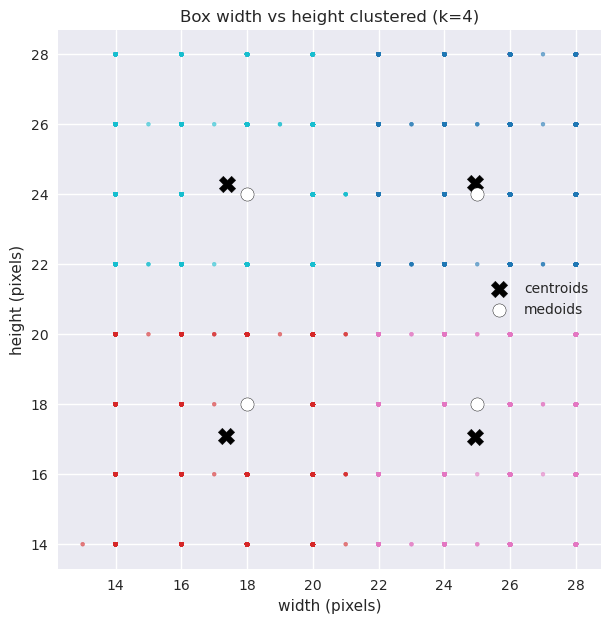

In [14]:
from sklearn.preprocessing import StandardScaler

# 4) scale and cluster (KMeans) choosing k by silhouette score
scaler = StandardScaler()
wh_scaled = scaler.fit_transform(wh)

best_k = None
best_score = -1
best_labels = None
best_centroids = None
k_range = range(2, 10)       # candidate k values for silhouette selection

for k in k_range:
    km = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = km.fit_predict(wh_scaled)
    score = silhouette_score(wh_scaled, labels)
    if score > best_score:
        best_score = score
        best_k = k
        best_labels = labels.copy()
        best_centroids = km.cluster_centers_.copy()

print(f"Selected k = {best_k} with silhouette = {best_score:.4f}")

centroids_pixels = scaler.inverse_transform(best_centroids)

print("Representative box sizes (width, height) in pixels (centroids):")
for i, c in enumerate(centroids_pixels):
    count = int((best_labels == i).sum())
    print(f"  cluster {i}: width={c[0]:.1f}, height={c[1]:.1f}, count={count}")

# 5) optional: compute medoids (actual observed sample per cluster)
def compute_medoids(samples, labels, k):
    medoids = []
    for cluster_id in range(k):
        members = samples[labels == cluster_id]
        if len(members) == 0:
            medoids.append(np.array([0.0, 0.0]))
            continue
        dists = np.linalg.norm(members[:, None, :] - members[None, :, :], axis=2)
        total = dists.sum(axis=1)
        medoid = members[np.argmin(total)]
        medoids.append(medoid)
    return np.vstack(medoids)

medoids = compute_medoids(wh, best_labels, best_k)
print("Medoid box sizes (actual examples) in pixels:")
for i, m in enumerate(medoids):
    print(f"  medoid {i}: width={m[0]:.1f}, height={m[1]:.1f}")

# 6) scatter plot with clusters, centroids and medoids
plt.figure(figsize=(7, 7))
plt.scatter(wh[:, 0], wh[:, 1], c=best_labels, s=8, cmap="tab10", alpha=0.6)
plt.scatter(centroids_pixels[:, 0], centroids_pixels[:, 1], c="black", s=140, marker="X", label="centroids")
plt.scatter(medoids[:, 0], medoids[:, 1], c="white", s=90, edgecolors="black", marker="o", label="medoids")
plt.xlabel("width (pixels)")
plt.ylabel("height (pixels)")
plt.title(f"Box width vs height clustered (k={best_k})")
plt.legend()
plt.grid(True)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


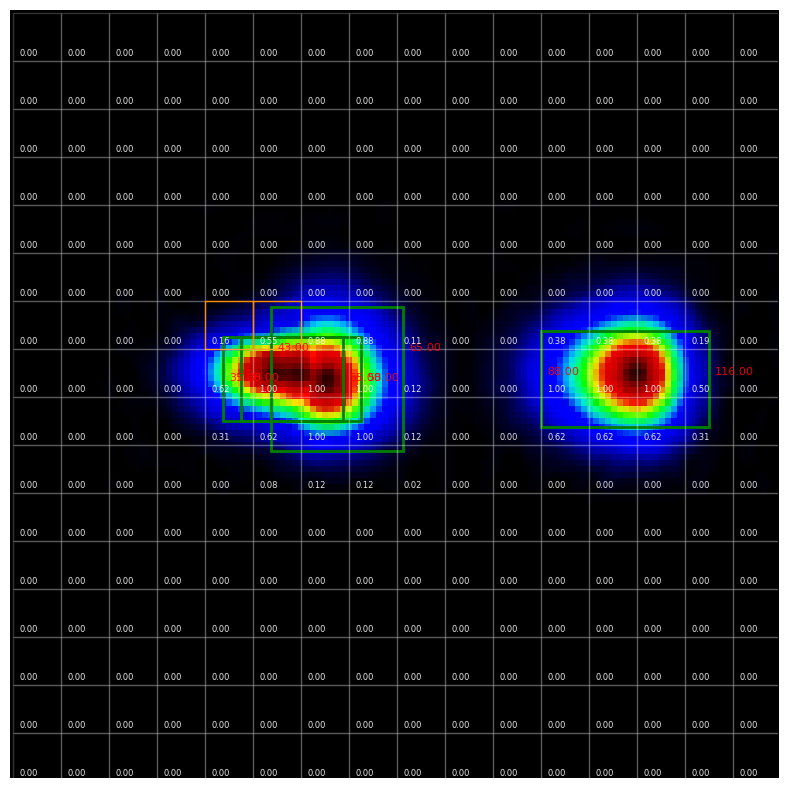

In [17]:
from matplotlib import patches

class tmp_AnchorGenerator():
    def __init__(self, stride=8, scales=[32, 64]):
        self.stride = stride
        self.scales = scales

    def generate(self, image_size):
        H = image_size[0] // self.stride
        W = image_size[1] // self.stride

        anchors = torch.empty((H * W * len(self.scales), 4), dtype=torch.float32)
        idx = 0
        for i in range(H):
            cy = (i + 0.5) * self.stride
            for j in range(W):
                cx = (j + 0.5) * self.stride
                
                for scale in self.scales:
                    scale = float(scale)
                    anchors[idx, 0] = cx - scale / 2
                    anchors[idx, 1] = cy - scale / 2
                    anchors[idx, 2] = cx + scale / 2
                    anchors[idx, 3] = cy + scale / 2
                    idx += 1

        return anchors


def tmp_compute_iou(boxes1, boxes2, mode="iom", eps=1e-8):
    M, N = boxes1.size(0), boxes2.size(0)

    # boxes1: [M, 4], boxes2: [N, 4]
    area1 = (boxes1[:,2] - boxes1[:,0]) * (boxes1[:,3] - boxes1[:,1])
    area2 = (boxes2[:,2] - boxes2[:,0]) * (boxes2[:,3] - boxes2[:,1])

    # intersection
    lt = torch.max(boxes1[:,None,:2], boxes2[:,:2])   # [M, N, 2]
    rb = torch.min(boxes1[:,None,2:], boxes2[:,2:])   # [M, N, 2]

    wh = (rb - lt).clamp(min=0)                        # [M, N, 2]
    inter = wh[:,:,0] * wh[:,:,1]                     # [M, N]

    if mode == "iou":
        union = area1[:,None] + area2[None,:] - inter
        return inter / (union + eps)

    elif mode == "ioa":
        return inter / (area1[:,None] + eps)

    elif mode == "iog":
        return inter / (area2[None,:] + eps)

    elif mode == "iom":
        min_area = torch.min(area1[:,None], area2[None,:])
        return inter / (min_area + eps)

    else:
        raise ValueError(f"Unknown overlap mode: {mode}")


def tmp_assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=0.5):
    B, M = gt_boxes.shape
    N = anchors.size(0)
    target_boxes = torch.zeros((B, N, 4), dtype=torch.float32, device=gt_boxes.device)
    object_mask = torch.zeros((B, N), dtype=torch.float32, device=gt_boxes.device)

    for b in range(B):
        valid_boxes = gt_boxes[b][gt_boxes[b].abs().sum(dim=-1) > 0]  # [M', 4]
        if valid_boxes.numel() == 0:
            continue

        ious = tmp_compute_iou(valid_boxes, anchors)  # [M', N]
        max_ious, max_idxs = ious.max(dim=0)  # [N]

        object_mask[b] = (max_ious > iou_threshold).float()
        target_boxes[b] = valid_boxes[max_idxs]  # assign best-matching box to each anchor
        
    return target_boxes, object_mask  # [B, N, 4], [B, N]


def tmp_draw_box(box, edgecolor):
    x1, y1, x2, y2 = box
    h, w = y2 - y1, x2 - x1
    rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=edgecolor, facecolor='none')
    ax.add_patch(rect)


# Load and resize
img, label = train_dataset_nobg.__getitem__(2)
img = img.permute(1,2,0).numpy()

# Generate anchors
stride_factor = IMAGE_SIZE[0]//pow(2,5)
pool_factor = 4
ag = tmp_AnchorGenerator(stride=8, scales=[8])#=[IMAGE_SIZE[0]/(IMAGE_SIZE[0]//30)])
anchors = ag.generate(IMAGE_SIZE)


# draw GT in red
gt_boxes = label['s_boxes']
# gt_boxes = gt_boxes[0].unsqueeze(0)
target_boxes, object_mask = tmp_assign_targets_to_anchors(gt_boxes, anchors, iou_threshold=0.50)
object_mask = object_mask[0, :]


# Set up plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(img)
ax.axis("off")

if gt_boxes is not None:
    for box in gt_boxes.tolist():
        xmin, ymin, xmax, ymax = box
        tmp_draw_box(box, edgecolor='g')
        ax.text(xmin + 1, ymin + 6, f"{xmin:.2f}", fontsize=8, color='red', alpha=0.9, verticalalignment="top")
        ax.text(xmax + 1, ymin + 6, f"{xmax:.2f}", fontsize=8, color='red', alpha=0.9, verticalalignment="top")

    ious = tmp_compute_iou(anchors, gt_boxes)
    # For each anchor, take the highest IoU against any l_box
    max_ious, _ = ious.max(dim=1)  # Tensor [num_anchors]

else:
    # fallback to zeros if no GT
    max_ious = torch.zeros(anchors.size(0))


# s_gt_boxes = label['s_boxes']
# if s_gt_boxes is not None:
#     for box in s_gt_boxes.tolist():
#         tmp_draw_box(box, edgecolor='r')


# Choose a colormap for different scales
colors = ["white", "violet", "darkorange", "green"]
scale_idx = (anchors[:,2] - anchors[:,0]).int()
scale_uid = torch.unique(scale_idx).sort().values
scale_idx = (scale_idx.unsqueeze(-1) == scale_uid).long()
scale_idx = scale_idx.argmax(dim=-1)

# Draw each anchor
for idx, (color, box, mask) in enumerate(zip(scale_idx, anchors, object_mask)):
    xmin, ymin, xmax, ymax = box.tolist()

    # Determine color by scale index
    if idx == 100:
        color += 2
        alpha = 1.0
        
    elif idx == 101:
        color += 2
        alpha = 1.0
        
    else:
        alpha = 0.2
    
    rect = patches.Rectangle(
        (xmin, ymin),
        xmax - xmin,
        ymax - ymin,
        linewidth=1,
        edgecolor=colors[color],
        facecolor="none",
        alpha=alpha
    )
    ax.add_patch(rect)

    # overlay IoU text (two decimal places)
    if mask >= 0:
        iou_val = max_ious[idx].item()
        ax.text(xmin + 1, ymin + 6, f"{iou_val:.2f}", fontsize=6, color='white', alpha=0.9, verticalalignment="top")

plt.tight_layout()
plt.show()


In [20]:
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim

writer = SummaryWriter(log_dir="runs/detector_experiment")

NUM_EPOCHS = 100
BATCH_SIZE = 32
LR = 0.001
warmup_epochs = 5
lambda_cls = 1.0
lambda_reg = 0.5
max_grad_norm = 5.0
patience = 10
max_focal_gamma = 2.0

model = HeatmapDetector(image_size=IMAGE_SIZE, scales=medoids[:,0]).to(DEVICE)

group_specs = [
    (model.conv1, 1e-6),
    (model.conv2, 1e-6),
    (model.conv3, 1e-6),
    (model.detector.box_head, 5e-4),
    (model.detector.cls_head, 1e-6),
]

bias_lr_factor = 0.1
param_groups = []
for module, base_lr in group_specs:
    # collect weight vs bias params
    w_params = [p for n, p in module.named_parameters() if n.endswith("weight")]
    b_params = [p for n, p in module.named_parameters() if n.endswith("bias")]

    # weight group: keep decay
    param_groups.append({
        "params": w_params,
        "lr": base_lr,
        "weight_decay": 1e-4,
    })

    # bias group: no decay
    param_groups.append({
        "params": b_params,
        "lr": base_lr * bias_lr_factor,
        "weight_decay": 0.0,
    })

optimizer = optim.AdamW(param_groups, betas=(0.9, 0.999))


In [21]:
'''
import torchvision

def log_predictions(images, gt_boxes, pred_offsets, step):
    # images: [B,3,H,W], gt_boxes: [B, M,4], pred_offsets: [B,N,4]
    anchors = model.anchors.to(images.device)
    # decode preds
    decoded_boxes = decode_offsets_to_boxes(pred_offsets, anchors)  # [B, N,4]

    for i in range(min(2, images.size(0))):  # log first 2 per batch
        img = (images[i] * 255).to(torch.uint8)  # un-normalize if needed
        gt = gt_boxes[i][gt_boxes[i].sum(dim=1) > 0]  # drop padded zeros
        
        # pick top-K predictions by objectness score
        scores = torch.sigmoid(pred_logits[i])
        topk = scores.topk(20).indices
        preds = decoded_boxes[i][topk]

        # draw
        gt_img = torchvision.utils.draw_bounding_boxes(img, gt, colors="green")
        pred_img = torchvision.utils.draw_bounding_boxes(img, preds, colors="red")
        
        # stack side by side
        both = torch.cat([gt_img, pred_img], dim=2)
        writer.add_image(f"preds_vs_gt/{i}", both, step)
'''

'\nimport torchvision\n\ndef log_predictions(images, gt_boxes, pred_offsets, step):\n    # images: [B,3,H,W], gt_boxes: [B, M,4], pred_offsets: [B,N,4]\n    anchors = model.anchors.to(images.device)\n    # decode preds\n    decoded_boxes = decode_offsets_to_boxes(pred_offsets, anchors)  # [B, N,4]\n\n    for i in range(min(2, images.size(0))):  # log first 2 per batch\n        img = (images[i] * 255).to(torch.uint8)  # un-normalize if needed\n        gt = gt_boxes[i][gt_boxes[i].sum(dim=1) > 0]  # drop padded zeros\n        \n        # pick top-K predictions by objectness score\n        scores = torch.sigmoid(pred_logits[i])\n        topk = scores.topk(20).indices\n        preds = decoded_boxes[i][topk]\n\n        # draw\n        gt_img = torchvision.utils.draw_bounding_boxes(img, gt, colors="green")\n        pred_img = torchvision.utils.draw_bounding_boxes(img, preds, colors="red")\n        \n        # stack side by side\n        both = torch.cat([gt_img, pred_img], dim=2)\n        wr

In [ ]:
best_val_loss = float("inf")
epochs_no_improve = 0

# total_steps = NUM_EPOCHS * len(train_loader)
total_steps = NUM_EPOCHS * (len(train_dataset_nobg) + len(train_dataset_bg)) // BATCH_SIZE

max_lr = [
    1e-4, 1e-4,   # conv1 weight, bias
    1e-4, 1e-4,   # conv2 weight, bias
    1e-4, 1e-4,   # conv3 weight, bias
    5e-2, 5e-2,   # box_head weight, bias
    1e-4, 1e-4    # cls_head weight, bias
]
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=warmup_epochs/NUM_EPOCHS, final_div_factor=5e2)
# scheduler_va = ValAwareOneCycle(optimizer, total_steps=total_steps, max_lr=0.1, trend='cosine', sensitivity=8.0, min_mod=0.6, max_mod=1.4)

run = Experiment(model, DEVICE, optimizer, scheduler, warmup_epochs, max_grad_norm)

for epoch in range(1, NUM_EPOCHS + 1):
    ramp = min(epoch / warmup_epochs, 1.0)
    current_lambda_cls = lambda_cls * ramp
    current_focal_gamma = max_focal_gamma * ramp

    mix_ratio = ramp
    mixed_ds = ConcatDataset([train_dataset_nobg, train_dataset_bg])

    # Assign per-sample weights for sampling
    w_synth = (1 - mix_ratio) / len(train_dataset_nobg)
    w_real  = mix_ratio / len(train_dataset_bg)
    weights = [w_synth] * len(train_dataset_nobg) + [w_real] * len(train_dataset_bg)

    sampler = WeightedRandomSampler(
        weights,
        num_samples = len(mixed_ds),
        replacement = True
    )

    train_loader = DataLoader(
        mixed_ds,
        batch_size = BATCH_SIZE,
        sampler = sampler,
        collate_fn = collate_fixed_boxes,
        shuffle = False # shuffle is disabled when using sampler
    )
    
    train_loss = run.train_one_epoch(train_loader, epoch, current_lambda_cls, lambda_reg, focal_gamma=current_focal_gamma)
    val_loss = run.validate_one_epoch(valid_loader, current_lambda_cls, lambda_reg)

    lrs = [group["lr"] for group in optimizer.param_groups]

    print(f"Epoch {epoch:02d} — LR: {sum(lrs) / len(lrs):.2e} — Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")

    # Early stopping check
    if epoch > warmup_epochs:
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "saves/best_detector.pth")
            epochs_no_improve = 0
            
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"No improvement for {patience} epochs. Early stopping.")
                break


Epoch 01 — LR: 1.33e-03 — Train Loss: 0.2089  Val Loss: 0.1596
Epoch 02 — LR: 3.75e-03 — Train Loss: 0.2390  Val Loss: 0.1734
Epoch 03 — LR: 6.75e-03 — Train Loss: 0.1927  Val Loss: 0.1212


In [ ]:
'''
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt

def load_scalars(logdir, tag):
    ea = event_accumulator.EventAccumulator(
        logdir,
        size_guidance={event_accumulator.SCALARS: 0}  # load all scalars
    )
    ea.Reload()
    events = ea.Scalars(tag)
    steps = [e.step for e in events]
    values = [e.value for e in events]
    return steps, values

def plot_grouped_tags(logdir, groups):
    """
    groups: dict[str, list[str]]
      mapping subplot title → list of TensorBoard tag names
    """
    fig, axes = plt.subplots(nrows=len(groups), ncols=1, figsize=(8, 4 * len(groups)))
    
    # If only one subplot, axes is not a list
    axes = np.atleast_1d(axes)

    for ax, (title, tags) in zip(axes, groups.items()):
        for tag in tags:
            steps, vals = load_scalars(logdir, tag)
            ax.plot(steps, vals, label=tag.split("/")[-1])
        ax.set_title(title)
        ax.set_xlabel("Global Step")
        ax.legend(loc="best")
        ax.grid(True)

    plt.tight_layout()
    plt.show()

LOGDIR = "runs/detector_experiment"

GROUPS = {
    "Conv Blocks": [
        "grad_norm/conv1.block.0.weight",
        "grad_norm/conv1.block.0.bias",
        "grad_norm/conv2.block.0.weight",
        "grad_norm/conv2.block.0.bias",
        "grad_norm/conv3.block.0.weight",
        "grad_norm/conv3.block.0.bias",
    ],
    "Box Head": [
        "grad_norm/detector.box_head.weight",
        "grad_norm/detector.box_head.bias",
    ],
    "Cls Head": [
        "grad_norm/detector.cls_head.weight",
        "grad_norm/detector.cls_head.bias",
    ],
}

plot_grouped_tags(LOGDIR, GROUPS)
'''

In [ ]:
model = HeatmapDetector(image_size=IMAGE_SIZE, scales=model.scales).to(DEVICE)

PATH = "saves/best_detector.pth"
model.load_state_dict(torch.load(PATH, map_location=DEVICE))

model.eval() is not None

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")


In [ ]:
import matplotlib.pyplot as plt

conf_logits_list = []
model.eval()
with torch.no_grad():
    images, _ = next(iter(valid_loader))
    images = images.to(DEVICE)
    _, conf_logits = model(images)
    conf_logits_list.append(conf_logits)
    conf_scores = torch.sigmoid(conf_logits)

conf_scores = conf_scores.cpu().flatten().numpy()
print(conf_scores)
plt.hist(conf_scores, bins=20, range=(0, 1))
plt.title("Confidence Score Distribution")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()


In [ ]:
def show_boxes_with_confidence(image_tensor, l_gt_boxes=None, s_gt_boxes=None, pred_boxes=None, confidences=None, conf_threshold=0.9, num_boxes=None, figsize=(8,8), box_kwargs=None, text_kwargs=None):
    """
    Draw GT (red) and predicted (blue) boxes.  
    If confidences is provided, writes 'c=0.83' at top-left of each pred box.
    """
    # defaults
    box_kwargs = box_kwargs or {}
    text_kwargs = text_kwargs or dict(color='white', fontsize=10, bbox=dict(facecolor='blue', alpha=0.5, pad=0.5))

    # prep image
    img = image_tensor.permute(1,2,0).numpy()

    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.axis('off')

    ax = plt.gca()

    def _draw_box(box, edgecolor):
        x1, y1, x2, y2 = box
        w,h = x2 - x1, y2 - y1
        rect = Rectangle((x1, y1), w, h, linewidth=2, edgecolor=edgecolor, facecolor='none', **box_kwargs)
        ax.add_patch(rect)

    # draw GT in red
    if l_gt_boxes is not None:
        for box in l_gt_boxes.tolist():
            _draw_box(box, edgecolor='g')

    if s_gt_boxes is not None:
        for box in s_gt_boxes.tolist():
            _draw_box(box, edgecolor='r')

    # draw preds in blue + text
    if pred_boxes is not None:
        best_boxes = dict(zip(confidences, pred_boxes))
        best_boxes = dict(sorted(best_boxes.items(), key=lambda item: -item[0]))
        best_boxes = list(best_boxes.items())
        if num_boxes:
            best_boxes = best_boxes[:num_boxes]
        
        for i, (conf, box) in enumerate(best_boxes):
            if conf >= conf_threshold:
                _draw_box(box, edgecolor='w')
                if confidences is not None:
                    x1,y1, x2, y2 = box
                    area = (x2 - x1) * (y2 - y1)
                    ax.text(x1, y1 - 2, f"{conf:.2f} --- {area:.2f}", **text_kwargs)

    plt.tight_layout()
    plt.show()



num_images = 10
init_image = random.randint(0, len(test_loader))
for batch in test_loader:
    inputs, labels = batch
    inputs = inputs.to(DEVICE)

    # Forward whole batch at once
    with torch.no_grad():
        all_coords, all_confs = model(inputs)
        all_coords = decode_offsets_to_boxes(all_coords, model.anchors)
        all_confs = torch.sigmoid(all_confs)

    # Loop over images in batch
    for img, l_gt, s_gt, coords, confs in zip(inputs[init_image:init_image+num_images], labels['l_boxes'][init_image:init_image+num_images], labels['s_boxes'][init_image:init_image+num_images], all_coords[init_image:init_image+num_images], all_confs[init_image:init_image+num_images]):
        # Move to CPU / numpy for printing & plotting
        img = img.to(DEVICE)
        H, W = img.shape[1:]
        l_gt = l_gt.to(DEVICE)
        s_gt = s_gt.to(DEVICE)

        coords = coords.to(DEVICE)   # list of [x1,y1,x2,y2]
        coords_px = coords
        coords_px = coords_px.tolist()

        confs = confs.to(DEVICE).tolist()    # list of floats in [0,1]

        print(f"Image shape: {img.shape}")
        print(f" GT boxes: {l_gt.shape}")
        print(f"Pred boxes+conf: {len(coords)} x 5\n")

        # Print each box + its confidence
        # for (x1,y1,x2,y2), c in zip(coords, confs):
        #     if c > 0.9:
        #         print(f"  → Box: [{x1:.4f},{y1:.4f},{x2:.4f},{y2:.4f}]  conf={c:.4f}")
        
        # print()

        # Visualize (with confidences overlaid)
        l_gt = None
        show_boxes_with_confidence(img, l_gt_boxes=l_gt, s_gt_boxes=s_gt, pred_boxes=coords, confidences=confs, conf_threshold=0.9, num_boxes=None)

    break